<a href="https://colab.research.google.com/github/libbyrose/ceos-db-toolkit/blob/main/colab-notebooks/Resolution_and_swath_width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

<i>This notebook aims to compare the resolutions and swath widths of instruments (filtered by date and/or measurement type)
    


In [ ]:
# Import API-related modules
import requests
import json

# Import for Quick Gantt Chart with Matplotlib example.
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import WEEKLY,MONTHLY,YEARLY, DateFormatter, rrulewrapper, RRuleLocator 
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Import to sort mission dates.
from operator import itemgetter, attrgetter

#Import for date conversion.
from dateutil import parser
import datetime
import time

#Import for SQL tables
import pandas as pd
from pandas import DataFrame


## Connect to Google Drive and the database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specify the path to yml file contating database access information

In [ ]:
# Specify the path in your local drive (use !ls and !pwd to hunt for it)
#Libby path: config_path='/content/drive/MyDrive/MIM Colab/config-libby.yml'
#George path:
config_path='/content/drive/MyDrive/Colab-MIM Notebooks/config.yml'
print('Getting CEOS Dev DB Config from: ' + config_path)

Getting CEOS Dev DB Config from: /content/drive/MyDrive/Colab-MIM Notebooks/config.yml


#### Save access information

In [ ]:
# Define SECRET database connection variables (MIM Dev DB on AWS RDS)
# Like YAML here: https://veekaybee.github.io/2020/02/25/secrets/
import yaml

with open(config_path, 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

user = cfg['ceos_dev_db']['user']
password = cfg['ceos_dev_db']['password']
database = cfg['ceos_dev_db']['database']
server = cfg['ceos_dev_db']['server']

#### Install DB Access Layer

A few code blocks to setup the necessary software to access the CEOS DB.

Define basic functions to access CEOS DB.

In [ ]:
# CHECK YOUR ODC COLAB VIRTUAL MACHINE IP ADDRESS
# The CEOS Dev DB is protected by whitelisting due to lots of attempts to query it
# Whitelisting means you can only connect from certain IP addresses

# Used this command to find the IP address of the Colab notebook (VM)
!curl ifconfig.me

# THE FOLLOWING RANGES HAVE BEEN WHITELISTED TO CONNECT TO THE AWS DATABASE
# 34.xxx.xxx.xxx
# 35.xxx.xxx.xxx
# 104.xxx.xxx.xxx

# IF YOUR VM IP IS NOT IN THIS RANGE* THEN IT WILL HAVE TO BE ADDED TO THE WHITELIST BEFORE IT WILL WORK (CONTACT GEORGE)
# * As a work around, you could start a new Colab notebook (VM) to see if you can get an IP address in the whitelist range.

104.199.193.238

In [ ]:
# Run this block to install the necessary DB interface code

%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list

sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

OK
Get:1 https://packages.microsoft.com/ubuntu/16.04/prod xenial InRelease [4,003 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 https://packages.microsoft.com/ubuntu/16.04/prod xenial/main amd64 Packages [258 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:14 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRele

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0   6874      0 --:--:-- --:--:-- --:--:--  6874
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    79  100    79    0     0    814      0 --:--:-- --:--:-- --:--:--   814
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 6.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
# Run this block to install the Python library to connect to the DB
!pip install pyodbc

     |████████████████████████████████| 280 kB 2.6 MB/s 
  Created wheel for pyodbc: filename=pyodbc-4.0.32-cp37-cp37m-linux_x86_64.whl size=287361 sha256=7fdbec5da9a465804e7b48b50e0a22b409fa84278f1a672c4441cabe842c5771
  Stored in directory: /root/.cache/pip/wheels/2e/9c/da/8652fd42e0f662015554f00a9e96fe4f438dfd1ef59787879e
Successfully built pyodbc


In [ ]:
# This this block to import the 'pyodbc' library
# pyodbc is used to connect Python (notebook) to the CEOS DB
# This import statment is how we include it when we're working on a local server
import pyodbc

In [ ]:
# Function to get DB cursor return
def get_db_cursor(user, password, database, server, t_sql):
  conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = server,
                      DATABASE = database,
                      UID = user,
                      PWD = password)

  db_cursor = conn.cursor()
  db_cursor.execute(t_sql)

  return db_cursor

In [ ]:
# Function that creates date variable.
def _create_date(datetxt):
    """Creates the date"""
    day,month,year=datetxt.split('-')
    date = dt.datetime(int(year), int(month), int(day))
    mdate = matplotlib.dates.date2num(date) 
    return mdate

## Select required filters



In [ ]:
#@title Choose maximum number of instruments to display 
max_no =  "All" #@param ['5', '10', '15', '20', 'All'] {type:"string"}

t_sql = '''SELECT Missions.missionNameShort, Missions.launchDate, Missions.eolDate, Instruments.instrumentID, Instruments.instrumentNameShort, Instruments.instrumentStatusID, 
        Instruments.instrumentSpatialResolutionBest, Instruments.instrumentSamplingID, OrbitTypes.orbitTypeID, Instruments.instrumentSwathWidthMax, TypesMeasurementsWMO.measurementTypeWMONameFull
FROM  Missions INNER JOIN
         InstrumentsMissions ON Missions.missionID = InstrumentsMissions.missionID INNER JOIN
         Instruments ON InstrumentsMissions.instrumentID = Instruments.instrumentID INNER JOIN
         MeasurementTypes ON InstrumentsMissions.instrumentID = MeasurementTypes.instrumentID INNER JOIN
         TypesMeasurementsWMO ON MeasurementTypes.measurementTypeWMOID = TypesMeasurementsWMO.measurementTypeWMOID LEFT OUTER JOIN
         OrbitTypes ON Missions.orbitTypeID = OrbitTypes.orbitTypeID LEFT OUTER JOIN
         SamplingInstrument ON Instruments.instrumentSamplingID = SamplingInstrument.instrumentSamplingID
WHERE ((Instruments.instrumentSpatialResolutionBest IS NOT NULL) OR (Instruments.instrumentSwathWidthMax IS NOT NULL ))'''


In [ ]:
#@title Define launch and EOL date ranges
filter_by_date =  True #@param ["True", "False"] {type:"raw"}

# Launch date window (Y,M,D)
launch_date_from = "2000-06-01" #@param {type:"date"}
launch_date_to = "2022-06-01" #@param {type:"date"}

launch_date_start = datetime.datetime(int(launch_date_from.split('-')[0]),int(launch_date_from.split('-')[1]),int(launch_date_from.split('-')[2]))
launch_date_end = datetime.datetime(int(launch_date_to.split('-')[0]),int(launch_date_to.split('-')[1]),int(launch_date_to.split('-')[2]))
# EOL date window (Y,M,D)

EOL_date_from = "1900-07-30" #@param {type:"date"}
EOL_date_to = "2100-07-30" #@param {type:"date"}

eol_date_start = datetime.datetime(int(EOL_date_from.split('-')[0]),int(EOL_date_from.split('-')[1]),int(EOL_date_from.split('-')[2]))
eol_date_end = datetime.datetime(int(EOL_date_to.split('-')[0]),int(EOL_date_to.split('-')[1]),int(EOL_date_to.split('-')[2]))

if filter_by_date:
  tsql_launchdate = """ Missions.launchDate > """ + "\'" + str(launch_date_start) + "\'" + """ 
    AND Missions.launchDate < """ + "\'" + str(launch_date_end) + "\'"

  tsql_eoldate = """Missions.eolDate > """ + "\'" + str(eol_date_start) + "\'" + """
    AND Missions.eolDate < """ + "\'" + str(eol_date_end) + "\'"

  t_sql = t_sql + 'AND ' + tsql_launchdate + 'AND ' + tsql_eoldate   

In [ ]:
#@title Filter by measurement
#@markdown List of measurements and IDs: https://docs.google.com/spreadsheets/d/13RSSiCP43_GgQl8LKeSn1jZ7yUSXiLQAgtieWKxlnLc/edit#gid=1499691144&range=A1 
filter_by_measurement = True #@param ["True", "False"] {type:"raw"}
measurement_type_WMOID =    34#@param {type:"integer"}

if filter_by_measurement:
  t_sql = t_sql + ' AND TypesMeasurementsWMO.measurementTypeWMOID = ' + str(measurement_type_WMOID)



In [ ]:
#@title Exclude specific missions
exclude_missions = False #@param ["True", "False"] {type:"raw"}
missionID_exclude = 642, 612 #@param {type:"raw"}

if exclude_missions:
  if len(str(missionID_exclude).split(',')) == 1:
    tsql_missionexclude = "(NOT (Missions.missionID IN (" + str(missionID_exclude) + ") ))"
  else:
    tsql_missionexclude = "(NOT (Missions.missionID IN " + str(missionID_exclude) + " ))"
  
  conditions = conditions + """
    AND """ + tsql_missionexclude

In [ ]:
#@title Filter out cancelled missions (or other specific statuses)
#@markdown List of statuses and IDs: https://docs.google.com/spreadsheets/d/13RSSiCP43_GgQl8LKeSn1jZ7yUSXiLQAgtieWKxlnLc/edit#gid=0&range=A1 
filter_by_status = True #@param ["True", "False"] {type:"raw"}
exclude_status_id = 5 #@param {type:"raw"}

if filter_by_status:
  if len(str(exclude_status_id).split(',')) == 1:
    tsql_status = "(NOT (Missions.missionStatusID IN (" + str(exclude_status_id) + ") ))"
  else:
    tsql_status = "(NOT (Missions.missionStatusID IN " + str(exclude_status_id) + " ))"
    
  t_sql =  t_sql + """
    AND """ + tsql_status

## Execute Query Response

<i>Map the query response to the field types to generate the timeline plot.</i>

In [ ]:
# Execute

print(t_sql)

db_cursor_return = get_db_cursor(user, password, database, server, t_sql) 

SELECT Missions.missionNameShort, Missions.launchDate, Missions.eolDate, Instruments.instrumentID, Instruments.instrumentNameShort, Instruments.instrumentStatusID, 
        Instruments.instrumentSpatialResolutionBest, Instruments.instrumentSamplingID, OrbitTypes.orbitTypeID, Instruments.instrumentSwathWidthMax, TypesMeasurementsWMO.measurementTypeWMONameFull
FROM  Missions INNER JOIN
         InstrumentsMissions ON Missions.missionID = InstrumentsMissions.missionID INNER JOIN
         Instruments ON InstrumentsMissions.instrumentID = Instruments.instrumentID INNER JOIN
         MeasurementTypes ON InstrumentsMissions.instrumentID = MeasurementTypes.instrumentID INNER JOIN
         TypesMeasurementsWMO ON MeasurementTypes.measurementTypeWMOID = TypesMeasurementsWMO.measurementTypeWMOID LEFT OUTER JOIN
         OrbitTypes ON Missions.orbitTypeID = OrbitTypes.orbitTypeID LEFT OUTER JOIN
         SamplingInstrument ON Instruments.instrumentSamplingID = SamplingInstrument.instrumentSampling

<i> Execute the SQL database query based on the chosen filters

In [ ]:
# Add mission names to ylables, mission dates to customDates.

instrument_info = []

# Interate over DB response rows (missions) and extract needed values.
# Noting brittle (bad practice!) of row indicies (e.g. row[5]) - could use a better solution here
for row in db_cursor_return:
    missionNameShort = str(row[0])
    launchDate = parser.parse(str(row[1]))
    eolDate = parser.parse(str(row[2]))

    instrument_ID = row[3]
    instrument_name = str(row[4])
    instrument_status = row[5]
    resolution = row[6]
    sampling = row[7]
    orbit = row[8]
    swath_width = row[9]

    if filter_by_measurement:
      measurement = str(row[10])

    instrument_info.append([missionNameShort, instrument_name, launchDate, eolDate, instrument_status, instrument_ID, resolution, sampling, orbit, swath_width])     
      

In [ ]:
# Close the DB cursor
db_cursor_return.close()

In [ ]:
# Sort mission info by launch date
instruments_sorted = sorted(instrument_info, key=itemgetter(2))

if max_no != 'All':
  cut_off = len(instruments_sorted) - (int(max_no) + 1)
  instruments_sorted = instruments_sorted[cut_off:]

## Create GanttChart

<i> Define a function for chart colours and shapes

In [ ]:
def colour_shape(status, orbit, sampling):

    # based off colours from database.eohandbook.com
    current = '#1b2490' # dark blue
    approved = '#717ce1' # light blue
    planned = '#006400' # dark green
    considered = '#72ae64' # light green

    colours_status = ['grey',        # 0 TBD
               current,       # 1 operational 
               'white',       # 2 default
               planned,       # 3 being developed
               approved,      # 4 approved
               considered,    # 5 proposed
               'red',         # 6 no longer considered
               'tomato',      # 7 no longer operational
               ]    

    colours_orbit = ['white', # 0 TBD
              'k',            # 1 GEO        
              'gold',         # 2 Sun-synchronos
              'gold' ,        # 3 Inclined, non-sun-synchronous
              'white',        # 4 Highly eliptical
              'white',        # 5 Earth-Sun L-1  
              ]

    shapes = ['s', # 0 TBD 
              's', # 1 Imaging
              'o', # 2 Sounding
              's', # 3 Other
              ]

    if sampling == None:
      sampling = 0
    if orbit == None:
      orbit = 0
    if status == None:
      status = 0
      

    return colours_status[status], colours_orbit[orbit], shapes[sampling]


In [ ]:
def marker_sizes(resolution, swath_width):
  if resolution == None:
    size_res = 0
  else:
    size_res = 5*np.log(float(resolution) + 1) + 1

  if swath_width == None:
    size_swath = 0
  else:
    size_swath = 0.8*np.log(float(swath_width) + 1) + 1  
  return size_res, size_swath

<i> Create a title for the plot based on active filters

In [ ]:
title = 'Swath Width and Resolution'

if filter_by_measurement:
  title = title + ': ' + measurement
  
#   if filter_by_agency:
#     title = title + ', '
    
# if filter_by_agency:
#   title = title + agency


print(title)      

Swath Width and Resolution: O3 Mole Fraction


<i>Define a function that makes the GanttChart

In [ ]:
def CreateResolutionChart(instruments_sorted, save_as_fig):
    """
        Create gantt charts with matplotlib
        Give mission lables and dates.
    """ 
    mission_names = [i[0] for i in instruments_sorted] 
    instrument_names = [i[1] for i in instruments_sorted]    
    customDates = [i[2:4] for i in instruments_sorted]
    status = [i[4] for i in instruments_sorted]

    urls = [r'http://database.eohandbook.com/database/instrumentsummary.aspx?instrumentID=' + str(i[5]) for i in instruments_sorted]
    resolution = [i[6] for i in instruments_sorted]
    sampling = [i[7] for i in instruments_sorted]
    orbit = [i[8] for i in instruments_sorted]
    swath_width = [i[9] for i in instruments_sorted]

# Define labels based on user defined options
    if ylabels_missionName and ylabels_instrumentName:
      ylabels = [i + ' (' + j + ')' for i, j in zip(instrument_names, mission_names)]
    elif ylabels_instrumentName:
      ylabels = instrument_names
    elif ylabels_missionName:
      ylabels = mission_names
    else:
      ylabels = len(mission_names)*['']     

    ilen=len(ylabels)
    pos = np.arange(0.5,ilen*0.5+0.5,0.5)

    size = (10,1.5*len(ylabels))
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)


    for i in range(len(ylabels)):
        face_colour,edge_colour,shape = colour_shape(status[i], orbit[i], sampling[i])
        size_res,size_swath = marker_sizes(resolution[i], swath_width[i])
        ax.plot(0, (i*0.5)+0.5, alpha = 1, marker=shape, markerfacecolor=face_colour, markersize=size_res, markeredgecolor = edge_colour, markeredgewidth=4) 
#        ax.plot(1.5, (i*0.5)+0.5, alpha = 0.8, marker='^', markerfacecolor=face_colour, markersize=size_swath, markeredgecolor = edge_colour, markeredgewidth=2) 
        if size_swath != 0:
          ax.barh((i*0.5)+0.5, 2*size_swath, left=-size_swath, height=0.4, align='center', edgecolor=edge_colour, linewidth=4, color=face_colour, alpha = 0.6)
        start_date,end_date = customDates[i]
        dates = start_date.strftime("%b %Y") + ' - ' + end_date.strftime("%b %Y")        
        ax.text(-15, (i*0.5)+0.7, dates, fontsize=12, color='k', ma='right')

        text = ''
        res = resolution[i]
        if res == None:
          str_res = 'N/A'
        elif res > 1000:
          res = round(res/1000, 1)
          str_res = str(res) + 'km '
        else:
          str_res = str(round(res)) + 'm'   

        swath = swath_width[i]        
        if swath == None:
          str_swath = 'N/A' 
        else:
          str_swath = str(round(swath)) + 'km ' 

        text = text + '''
      Resolution: ''' + str_res + '''
      Swath Width: ''' + str_swath
        ax.text(9.3, (i*0.5)+0.61, text, fontsize=11.5, color='k')

    ax.text(-10, (i*0.5)+1.1, 'Note: a logarithmic scaling is used for the size of the bars and shapes', fontsize=12)
    locsy, labelsy = plt.yticks(pos,ylabels)
    plt.setp(labelsy, fontsize = 14)

    ax.set_ylim(ymin = -0.1, ymax = ilen*0.5+0.5)
    ax.grid(axis='y',color = 'k', linestyle = ':')
 
    ax.invert_yaxis()
    plt.xlim(-10,10)
    ax.axes.xaxis.set_visible(False)


# Code below is to create custom legend

    rectangle = plt.Rectangle((15,0),7,2.5, fc='0.85',ec="k", clip_on=False, linewidth=3)
    ax.add_patch(rectangle)

    legend_title = 'Status \n \n \n \n \n \n \n Orbit \n \n \n \n Sampling'
    legend_text = '''
        Current
        Approved
        Planned
        Considered
        TBD
        Complete \n 
        GEO
        LEO
        Other
        '''
    legend_text2 = '''
        Sounding
        Imaging/Other'''

    ax.text(15.5,0.1,legend_text, fontsize=15, va='top', linespacing=1.8)
    ax.text(15.5,1.8,legend_text2, fontsize=15, va='top', linespacing=2.7)
    ax.text(15.5,0.1,legend_title, fontsize=15, va='top', linespacing=1.8, weight='bold')

    gap = 0.16
    start = 0.25
    ax.add_patch(plt.Rectangle((15.6,start+0*gap), 1, 0.1, fc=colour_shape(1,0,0)[0], clip_on=False))
    ax.add_patch(plt.Rectangle((15.6,start+1*gap), 1, 0.1, fc=colour_shape(4,0,0)[0], clip_on=False))
    ax.add_patch(plt.Rectangle((15.6,start+2*gap), 1, 0.1, fc=colour_shape(3,0,0)[0], clip_on=False))
    ax.add_patch(plt.Rectangle((15.6,start+3*gap), 1, 0.1, fc=colour_shape(5,0,0)[0], clip_on=False))
    ax.add_patch(plt.Rectangle((15.6,start+4*gap), 1, 0.1, fc=colour_shape(0,0,0)[0], clip_on=False))
    ax.add_patch(plt.Rectangle((15.6,start+5*gap), 1, 0.1, fc=colour_shape(7,0,0)[0], clip_on=False))

    start = 1.35
    ax.add_patch(plt.Rectangle((15.6,start+0*gap), 1, 0.1, ec=colour_shape(0,1,0)[1], clip_on=False, fc='0.85', linewidth=3))
    ax.add_patch(plt.Rectangle((15.6,start+1*gap), 1, 0.1, ec=colour_shape(0,2,0)[1], clip_on=False, fc='0.85', linewidth=3))
    ax.add_patch(plt.Rectangle((15.6,start+2*gap), 1, 0.1, ec=colour_shape(0,0,0)[1], clip_on=False, fc='0.85', linewidth=3))

    start = 1.99 + 0.5*gap
    ax.add_patch(mpatches.Ellipse((16.1, start), 1, 0.18, fc='1', clip_on=False, ec='0'))
    ax.add_patch(plt.Rectangle((15.6, start+gap), 1, 0.18, fc='1', clip_on=False, ec='0'))
    plt.title(title, fontsize=20)

    ax.text(-8,0.1,'Bars: Swath Width       Shapes: Resolution', fontsize='16', ma='center')
    
    if save_as_fig:
      filename = 'drive/MyDrive/CEOS Database Timeline: ' + title + '.jpg'
      plt.savefig(filename)

    plt.show()


    

## Chart Output

In [ ]:
#@markdown Choose what is displayed on the y_axis 
ylabels_missionName = True #@param ["True", "False"] {type:"raw"}
ylabels_instrumentName = True #@param ["True", "False"] {type:"raw"}

#@markdown Choose whether to save as figure
save_as_fig = True #@param ["True", "False"] {type:"raw"}

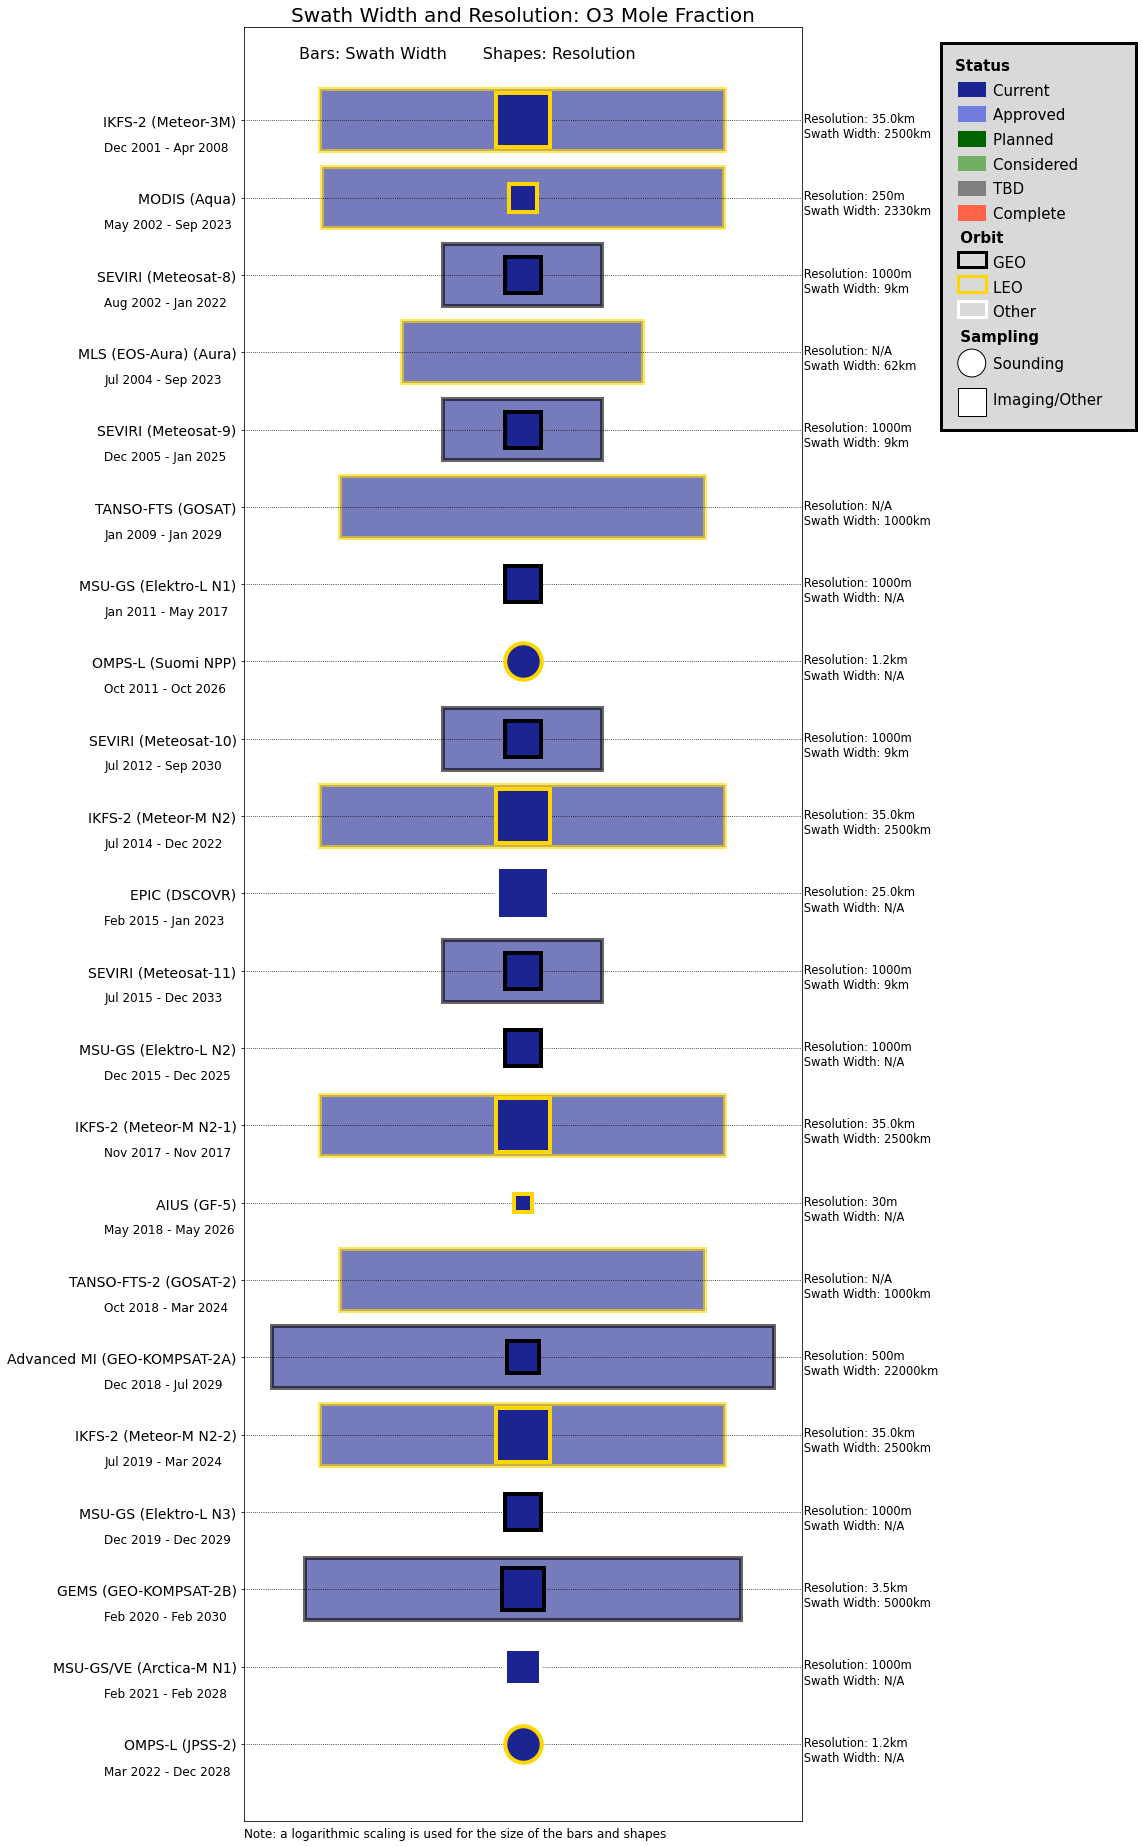

In [ ]:
CreateResolutionChart(instruments_sorted, save_as_fig)

In [ ]:
#@title Export as spreadsheet
#@markdown Find the google sheet at https://sheets.google.com
export_as_spreadsheet = False #@param ["True", "False"] {type:"raw"}

if export_as_spreadsheet:

  # Save data as google sheets
  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from oauth2client.client import GoogleCredentials

  gc = gspread.authorize(GoogleCredentials.get_application_default())



  mission_names = ['Mission Name Short'] + [i[0] for i in missions_sorted] 
  launch_date = ['Launch Date'] + [i[2] for i in missions_sorted]
  eol_date = ['EOL Date'] + [i[2] for i in missions_sorted]
  status = ['Mission Status'] + [i[4] for i in missions_sorted]
  mission_id = ['Mission ID'] + [i[5] for i in missions_sorted]

  # Open our new sheet and add some data.
  sheet_title = 'CEOS Database Timelines: ' + title
  sh = gc.create(sheet_title)
  worksheet = gc.open(sheet_title).sheet1

  cell_list = worksheet.range('A1:A'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = mission_id[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('B1:B'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = mission_names[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('C1:C'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = str(launch_date[i])
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('D1:D'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = str(eol_date[i])
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('E1:E'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = status[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('F1:F'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    if i == 0:
      cell_list[i].value = 'Link to Database'
    else:
      cell_list[i].value = r'http://database.eohandbook.com/database/missionsummary.aspx?missionID=' + str(mission_id[i])  
  worksheet.update_cells(cell_list)

  # Go to https://sheets.google.com to see your new spreadsheet.